## Vision Project


In [23]:
import torch, lab_utils, random
from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os as os
from PIL import Image
import json, string
%matplotlib inline

### Pytorch's pretrained Convolutional Neural Networks

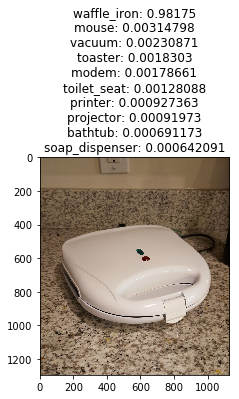

In [33]:
# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('test_image.jpg').convert('RGB')
# Try your own image here. This is a picture of my toaster at home.
inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = resnet(inputVar)

# 4. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions)).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
plt.title(string.join(preds, '\n'))
plt.imshow(image);

### Train Model:  Definition

In [ ]:
def train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        
        scheduler.step()
        
        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)   

#### Dataset and Network Definition - Cats and Dogs

In [10]:
# I split the trainset and valset into two subfolders "cat" and "dog"  i.e. cats_dogs/trainset/cats and cats_dogs/trainset/dogs, etc
# This allowed me to use pytorch's ImageFolder method to use the directory name as the class label.
# Reference:  http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = {
    'trainset': transforms.Compose([transforms.Scale((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                         (0.229, 0.224, 0.225))]),
    'valset': transforms.Compose([transforms.Scale((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), 
                                                       (0.229, 0.224, 0.225))])}
data_dir = 'cats_dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['trainset', 'valset']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['trainset', 'valset']}
class_names = image_datasets['trainset'].classes
trainLoader = torch.utils.data.DataLoader(image_datasets['trainset'], batch_size = 64, shuffle = True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(image_datasets['valset'], batch_size = 64, shuffle = False, num_workers = 0)    
    
        
# Definition of our network.
network = models.resnet18(pretrained = True)
network.fc = nn.Linear(512,2)
network.train()
learningRate = 1e-3 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(network.parameters(), lr = learningRate, weight_decay = 0.001)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,7,8],gamma=0.4);
train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

#### Example Classifications - Cats and Dogs


Image 749


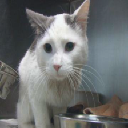

Image predicted as cats with confidence 1.00
y_hat[cats] = 1.00
y_hat[dogs] = 0.00

Image 4861


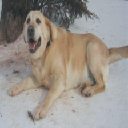

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00

Image 1141


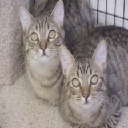

Image predicted as cats with confidence 1.00
y_hat[cats] = 1.00
y_hat[dogs] = 0.00

Image 2719


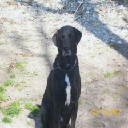

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00

Image 4047


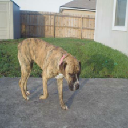

Image predicted as dogs with confidence 1.00
y_hat[cats] = 0.00
y_hat[dogs] = 1.00


In [29]:
# Randomly select 5 images from the validation set
network.eval()

# Import class names (from dataloader, above)
classes = class_names

# Now predict the category using this trained classifier
for i in range(0, 5):
    img_id = random.randint(0, 5000) # 5000 images in this validation set
    print('\nImage %d' % img_id)
    img, _ = image_datasets['valset'][img_id]
    predictions = F.softmax(network(Variable(img.unsqueeze(0)).cuda()))
    predictions = predictions.data

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(un_normalize(img)).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

    # Print out detailed predictions.
    for (i, pred) in enumerate(predictions.squeeze().tolist()):
        print('y_hat[%s] = %.2f' % (classes[i], pred))